---
# **Dependencies**
---

In [ ]:
#한글 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#런타임 다시 시작
import os
os.kill(os.getpid(), 9)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,794 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

---
# **Import Packages**
---

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')
mount_dir = '/content/drive/MyDrive/weather_con'

sns.set_style("white")
sns.set_context("talk")
plt.rc('font', family='NanumBarunGothic')

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import plotly.io as pio
import plotly.express as px
pio.templates.default = "plotly_white"

Mounted at /content/drive


---
# **IMPORT DATA**
---

### 심뇌혈관질환 입원자 수

In [2]:
############# 백병원 데이터 #############
## 심뇌혈관질환 입원자 수 데이터(2012 ~ 2015)
back_dat = pd.read_csv(mount_dir+'/back_hospital.csv', encoding='utf8', index_col=0)
back_dat.columns = ["date", "area", "sex", "freq"]
back_dat['date'] = pd.to_datetime(back_dat['date'], format = '%Y%m%d')
back_dat['year'] = back_dat['date'].dt.year
back_dat['month'] = back_dat['date'].dt.month
back_dat['weekday'] = back_dat['date'].dt.strftime("%A")
back_dat['weekday'] = pd.Categorical(back_dat['weekday'],categories=[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'],ordered=True)
back_dat['area'] = pd.Categorical(back_dat['area'])
#### 지역, 요일 정수로 넣을 때 코드 
#back_dat['wd'] = back_dat['date'].dt.strftime("%w") # 0은 일요일이고 6은 토요일
#back_dat['area_n'] = pd.Categorical(back_dat['area']).codes

#### year+month로 CV를 위한 변수
def monmon(x) :
    if x < 10 :
        return '0'+str(x)
    else : 
        return str(x)
back_dat['yyyymm'] = back_dat['year'].astype('str') + back_dat['month'].apply(monmon)

#### 계절 변수
seasons = ['겨울', '겨울', '봄', '봄', '봄', '여름', '여름', '여름', '가을','가을','가을', '겨울' ]
month_to_season = dict(zip(range(1,13), seasons))
back_dat['season'] = back_dat['month'].map(month_to_season)
back_dat['season'] = pd.Categorical(back_dat['season'],categories=[ '봄', '여름', '가을', '겨울'],ordered=True)

#### 시각화를 위한 한글 요일 변수
kor_weekday = ['일', '월', '화', '수', '목', '금', '토']
eng_to_kor = dict(zip(back_dat['weekday'].unique(), kor_weekday))
back_dat['kor_weekday'] = back_dat['weekday'].map(eng_to_kor)

### 강수 데이터

In [3]:
############# 날씨 데이터 #############
## 강수 데이터 (2012~2015)
awscode2= pd.read_csv(mount_dir+'/awscode2.csv', encoding='utf8') 

raindt = pd.read_csv(mount_dir+'/rainfall.csv', encoding='CP949', index_col=0)
raindt['date'] = raindt['tma'].str[0:10]
raindt = raindt.groupby(['date', 'stn_id']).mean().reset_index()
raindt = pd.merge(raindt, awscode2, how='inner', left_on='stn_id', right_on='stn_id')
raindt.drop(['stn_id'], axis=1, inplace=True)
raindt = raindt.groupby(['date', 'area']).mean().reset_index()
raindt['date'] = pd.to_datetime(raindt['date'], format = '%Y-%m-%d')

## 강수 데이터 (2016)
raintempdt = pd.read_csv(mount_dir+'/temp_rain2016.csv', encoding='CP949', index_col=0) #16년도 데이터, 강수량과 기온이 합쳐져 있음
raindt2016 = raintempdt[['일시', '일강수량(mm)']].reset_index()
raindt2016.columns = ['stn_id', 'date', 'sum_rn']
raindt2016 = pd.merge(raindt2016, awscode2, how='inner', left_on='stn_id', right_on='stn_id')
raindt2016.drop(['stn_id'], axis=1, inplace=True)
raindt2016 = raindt2016.groupby(['date', 'area']).mean().reset_index()
raindt2016['date'] = pd.to_datetime(raindt2016['date'], format = '%Y-%m-%d')

print(len(raindt), len(raindt2016))

24837 6222


In [4]:
raindt

,date,area,sum_rn
0,2012-01-01,강원,0.142857
1,2012-01-01,경기,0.031250
2,2012-01-01,경남,0.047170
3,2012-01-01,경북,0.624638
4,2012-01-01,광주,0.750000
...,...,...,...
24832,2015-12-31,전남,1.493103
24833,2015-12-31,전북,0.987805
24834,2015-12-31,제주,0.911429
24835,2015-12-31,충남,0.166667


In [5]:
raindt2016

,date,area,sum_rn
0,2016-01-01,강원,0.000000
1,2016-01-01,경기,0.000000
2,2016-01-01,경남,0.000000
3,2016-01-01,경북,0.000000
4,2016-01-01,광주,0.000000
...,...,...,...
6217,2016-12-31,전남,0.000000
6218,2016-12-31,전북,0.000000
6219,2016-12-31,제주,0.000000
6220,2016-12-31,충남,0.045455


### 대기오염 물질 (2012~2015)

In [6]:
## 대기오염 물질 (2012~2015)
air1201 = pd.read_csv(mount_dir+'/2012년1분기.csv', encoding='CP949', index_col=0)
air1202 = pd.read_csv(mount_dir+'/2012년2분기.csv', encoding='CP949', index_col=0)
air1203 = pd.read_csv(mount_dir+'/2012년3분기.csv', encoding='CP949', index_col=0)
air1204 = pd.read_csv(mount_dir+'/2012년4분기.csv', encoding='CP949', index_col=0)

air1301 = pd.read_csv(mount_dir+'/2013년1분기.csv', encoding='CP949', index_col=0)
air1302 = pd.read_csv(mount_dir+'/2013년2분기.csv', encoding='CP949', index_col=0)
air1303 = pd.read_csv(mount_dir+'/2013년3분기.csv', encoding='CP949', index_col=0)
air1304 = pd.read_csv(mount_dir+'/2013년4분기.csv', encoding='CP949', index_col=0)

air1401 = pd.read_csv(mount_dir+'/2014년 1분기.csv', encoding='CP949', index_col=0)
air1402 = pd.read_csv(mount_dir+'/2014년 2분기.csv', encoding='CP949', index_col=0)
air1403 = pd.read_csv(mount_dir+'/2014년 3분기.csv', encoding='CP949', index_col=0)
air1404 = pd.read_csv(mount_dir+'/2014년 4분기.csv', encoding='CP949', index_col=0)

air1501 = pd.read_csv(mount_dir+'/2015년1분기.csv', encoding='utf8', index_col=0)
air1502 = pd.read_csv(mount_dir+'/2015년2분기.csv', encoding='utf8', index_col=0)
air1503 = pd.read_csv(mount_dir+'/2015년3분기.csv', encoding='utf8', index_col=0)
air1504 = pd.read_csv(mount_dir+'/2015년4분기.csv', encoding='utf8', index_col=0)

air12 = pd.concat([air1201, air1202, air1203, air1204])
air13 = pd.concat([air1301, air1302, air1303, air1304])
air14 = pd.concat([air1401, air1402, air1403, air1404])
air15 = pd.concat([air1501, air1502, air1503, air1504])
airdt = pd.concat([air12, air13, air14, air15]).reset_index()
airdt = airdt.replace(-999, np.nan)

code = [533112, 533114, 533115, 533116, 633211] + [534111,534112,534111]
airdt_sejong = airdt[airdt['측정소코드'].isin(code)].copy().reset_index(drop=True)
airdt_sejong['지역'] = '세종'
airdt = pd.concat([airdt, airdt_sejong], axis=0)
airdt.drop(['측정소코드', '측정소명', 'PM25', '주소'], axis=1, inplace=True)
airdt['측정일시'] = airdt['측정일시'].astype(str)
airdt['측정일시'] = pd.to_datetime(airdt['측정일시'].str[0:8], format = '%Y%m%d')
airdt.rename(columns = {'지역' : 'area', '측정일시' : 'date'}, inplace=True)
airdt['area'] = airdt['area'].str[0:2]
airdt = airdt.groupby(['area', 'date']).mean().reset_index()
airdt['date'] = pd.to_datetime(airdt['date'], format = '%Y-%m-%d')

## 대기오염 물질 (2016)
air1601 = pd.read_csv(mount_dir+'/2016년 1분기.csv', encoding='CP949', index_col=0)
air1602 = pd.read_csv(mount_dir+'/2016년 2분기.csv', encoding='CP949', index_col=0)
air1603 = pd.read_csv(mount_dir+'/2016년 3분기.csv', encoding='CP949', index_col=0)
air1604 = pd.read_csv(mount_dir+'/2016년 4분기.csv', encoding='CP949', index_col=0)

air2016 = pd.concat([air1601, air1602, air1603, air1604], axis=0).reset_index()
air2016 = air2016.replace(-999, np.nan)
air2016_sejong = air2016[air2016['측정소코드'].isin(code)].copy().reset_index(drop=True)
air2016_sejong['지역'] = '세종'
air2016 = pd.concat([air2016, air2016_sejong], axis=0)
air2016.drop(['측정소코드', '측정소명', 'PM25', '주소'], axis=1, inplace=True)
air2016['측정일시'] = air2016['측정일시'].astype(str)
air2016['측정일시'] = pd.to_datetime(air2016['측정일시'].str[0:8], format = '%Y%m%d')
air2016.rename(columns = {'지역' : 'area', '측정일시' : 'date'}, inplace=True)
air2016['area'] = air2016['area'].str[0:2]
air2016 = air2016.groupby(['area', 'date']).mean().reset_index()
air2016['date'] = pd.to_datetime(air2016['date'], format = '%Y-%m-%d')

print(len(airdt), len(air2016))

24837 6222


In [7]:
airdt

,area,date,SO2,CO,O3,NO2,PM10
0,강원,2012-01-01,0.010033,1.012879,0.019098,0.020873,84.337500
1,강원,2012-01-02,0.007540,1.053257,0.017183,0.021438,75.334677
2,강원,2012-01-03,0.007662,0.967308,0.018231,0.022224,89.079365
3,강원,2012-01-04,0.011952,0.738636,0.024720,0.016582,75.596958
4,강원,2012-01-05,0.005407,0.707576,0.022117,0.019686,59.391635
...,...,...,...,...,...,...,...
24832,충북,2015-12-27,0.005602,0.529924,0.018693,0.017147,44.477273
24833,충북,2015-12-28,0.005153,0.556154,0.011900,0.024010,36.046332
24834,충북,2015-12-29,0.005801,0.809470,0.007439,0.029926,54.507576
24835,충북,2015-12-30,0.005311,0.822348,0.007280,0.028694,62.651515


In [8]:
air2016

,area,date,SO2,CO,O3,NO2,PM10
0,강원,2016-01-01,0.004080,0.822500,0.019188,0.019066,55.840336
1,강원,2016-01-02,0.004768,0.761667,0.025142,0.017350,49.324324
2,강원,2016-01-03,0.006452,1.070000,0.023921,0.019861,68.203390
3,강원,2016-01-04,0.005225,0.791597,0.031283,0.017922,73.858333
4,강원,2016-01-05,0.003743,0.530702,0.023715,0.014826,26.977974
...,...,...,...,...,...,...,...
6217,충북,2016-12-27,0.003186,0.504643,0.015589,0.019990,37.452297
6218,충북,2016-12-28,0.004027,0.592883,0.007324,0.028854,45.156584
6219,충북,2016-12-29,0.003783,0.535764,0.012149,0.023849,37.128920
6220,충북,2016-12-30,0.003835,0.654514,0.008958,0.026286,37.454545


### 피해연보 데이터 (강풍, 호우, 태풍, 대설)

In [9]:
disaster = pd.read_csv(mount_dir+'/disaster.csv', encoding='utf8')
disaster['date'] = pd.to_datetime(disaster['date'], format = '%Y-%m-%d')
disaster

,date,area,strong_wind,heavy_rain,typhoon,heavy_snow
0,2012-03-11,경기,1,0,0,0
1,2012-04-02,부산,1,0,0,0
2,2012-04-02,인천,1,0,0,0
3,2012-04-02,광주,1,0,0,0
4,2012-04-02,울산,1,0,0,0
...,...,...,...,...,...,...
1046,2016-10-06,경남,0,0,1,0
1047,2016-10-03,제주,0,0,1,0
1048,2016-10-04,제주,0,0,1,0
1049,2016-10-05,제주,0,0,1,0


### ASOS 기상 데이터

In [10]:
## ASOS 기상 데이터
## ASOS 이상치 처리를 위한 작업
asoscode = pd.read_csv(mount_dir+'/asoscode.csv', encoding='CP949') 
asoscode[asoscode['지점명']=='청주']['area'] == '충북'
asoscode[asoscode['지점명']=='천안']['area'] == '충남'
code_to_insert = {'지점': 239, '지점명': '세종', 'area': '세종'}
asoscode = asoscode.append(code_to_insert, ignore_index=True)

asos = pd.read_csv(mount_dir+'/asosdt.csv', encoding='CP949')
weacol = ['yyyymmdd', '지점', '지점명', '최저기온(°C)', '최고기온(°C)', '평균 풍속(m/s)','평균 이슬점온도(°C)', '최소 상대습도(%)', '평균 상대습도(%)', '최고 해면기압(hPa)','최저 해면기압(hPa)', '합계 일조시간(hr)']
asos = asos[weacol].copy()

# 세종 전체 결측
areacode_sj = ['천안', '청주']
asos_sj = asos[asos['지점명'].isin(areacode_sj)].copy().reset_index(drop=True)
asos_sj['지점'] = 239
asos_sj['지점명'] = '세종'

# 대구 특정 날짜 결측
areacode_dg = ['합천', '구미']
asos_dg = asos[(asos['지점명'].isin(areacode_dg))&(asos['yyyymmdd']=='2013-09-30')].copy().reset_index(drop=True)
asos_dg['지점'] = 143
asos_dg['지점명'] = '대구'

# 대전 특정 날짜, 특정 변수 결측
areacode_dj = ['금산', '청주']
asos_dj = asos[(asos['지점명'].isin(areacode_dj))&(asos['yyyymmdd']=='2015-05-16')].copy().reset_index(drop=True)
asos_dj['지점'] = 133
asos_dj['지점명'] = '대전'
## 결측치 채우기
asos.loc[(asos['yyyymmdd']=='2015-05-16')&(asos['지점명']=='대전'),'평균 상대습도(%)'] = asos_dj['평균 상대습도(%)'].mean()

# 부산 특정 날짜, 특정 변수 결측
areacode_bs = ['울산', '거제']
asos_bs = asos[(asos['지점명'].isin(areacode_bs))&((asos['yyyymmdd']=='2016-01-31')|(asos['yyyymmdd']=='2016-02-01'))].copy().reset_index(drop=True)
asos_bs['지점'] = 159
asos_bs['지점명'] = '부산'
## 결측치 채우기
asos.loc[(asos['yyyymmdd']=='2016-01-31')&(asos['지점명']=='부산'),'최고 해면기압(hPa)'] = asos_bs.loc[asos_bs['yyyymmdd']=='2016-01-31', '최고 해면기압(hPa)'].mean()
asos.loc[(asos['yyyymmdd']=='2016-02-01')&(asos['지점명']=='부산'),'최고 해면기압(hPa)'] = asos_bs.loc[asos_bs['yyyymmdd']=='2016-02-01', '최고 해면기압(hPa)'].mean()

# 대구 특정 날짜, 특정 변수 결측
dg1 = asos[(asos['지점명'].isin(areacode_dg))&(asos['yyyymmdd']=='2014-12-04')].copy().reset_index(drop=True)
dg1['지점'] = 143
dg1['지점명'] = '대구'
dg2 = asos[(asos['지점명'].isin(areacode_dg))&(asos['yyyymmdd']=='2015-11-02')].copy().reset_index(drop=True)
dg2['지점'] = 143
dg2['지점명'] = '대구'

## 결측치 채우기
asos.loc[(asos['yyyymmdd']=='2014-12-04')&(asos['지점명']=='대구'),'평균 풍속(m/s)'] = dg1['평균 풍속(m/s)'].mean()
asos.loc[(asos['yyyymmdd']=='2015-11-02')&(asos['지점명']=='대구'),'최고 해면기압(hPa)'] = dg1['최고 해면기압(hPa)'].mean()

# 최저 해면기압 - 이상치 탐지
# 2015년 12월 30일만 태풍이 없던 날이고 해당 날짜 주변 지점의 값이 크게 차이나므로 이상치로 판단
# 제주 내 다른 지점의 값으로 대체
jeju = ['성산포', '성산', '고산', '제주']
asos.loc[asos['최저 해면기압(hPa)']<=950,'최저 해면기압(hPa)'] = asos[(asos['지점명'].isin(jeju))&(asos['yyyymmdd']=='2015-12-30')]['최저 해면기압(hPa)'].mean()

# 합계 일조시간 - 이상치 탐지
# 하루 24시간의 범위를 벗어나는 값 출력, 2값을 제외한 모든 값이 15시간 이내
# 근처 다른 지점의 값으로 대체
gy = ['순천', '여수', '진주']
asos.loc[(asos['yyyymmdd']=='2015-06-06')&(asos['지점명']=='광양시'),'합계 일조시간(hr)'] = asos[(asos['지점명'].isin(gy))&(asos['yyyymmdd']=='2015-06-06')]['합계 일조시간(hr)'].mean()
asos.loc[(asos['yyyymmdd']=='2015-07-19')&(asos['지점명']=='광양시'),'합계 일조시간(hr)'] = asos[(asos['지점명'].isin(gy))&(asos['yyyymmdd']=='2015-07-19')]['합계 일조시간(hr)'].mean()



asos = pd.concat([asos, asos_sj, asos_dg], axis=0).reset_index(drop=True)
asos = pd.merge(asos, asoscode, how='left', left_on=('지점', '지점명'), right_on=('지점', '지점명'))

asos.drop(['지점'], axis=1, inplace=True)
asos = asos.groupby(['yyyymmdd', 'area']).mean().reset_index()
asos['yyyymmdd'] = pd.to_datetime(asos['yyyymmdd'], format = '%Y-%m-%d')

### 전처리
asos['일교차'] = asos['최고기온(°C)'] - asos['최저기온(°C)']
asos['기압차'] = asos['최고 해면기압(hPa)'] - asos['최저 해면기압(hPa)']
#asos.drop(columns=['최고기온(°C)', '최고 해면기압(hPa)'], inplace=True)

asosdt = asos[asos['yyyymmdd'] < datetime(2016,1,1)]
asos2016 = asos[asos['yyyymmdd'] >= datetime(2016,1,1)]

print(len(asosdt), len(asos2016))

24837 6222


In [11]:
asosdt

,yyyymmdd,area,최저기온(°C),최고기온(°C),평균 풍속(m/s),평균 이슬점온도(°C),최소 상대습도(%),평균 상대습도(%),최고 해면기압(hPa),최저 해면기압(hPa),합계 일조시간(hr),일교차,기압차
0,2012-01-01,강원,-6.607692,1.553846,2.115385,-9.200000,40.769231,62.530769,1025.369231,1019.353846,3.707692,8.161538,6.015385
1,2012-01-01,경기,-8.180000,0.720000,1.720000,-8.380000,44.200000,71.220000,1027.080000,1021.920000,2.580000,8.900000,5.160000
2,2012-01-01,경남,-3.250000,6.650000,2.250000,-6.192857,41.642857,59.228571,1024.850000,1019.528571,2.242857,9.900000,5.321429
3,2012-01-01,경북,-4.800000,4.621429,3.057143,-7.307143,43.285714,60.007143,1024.314286,1018.521429,3.228571,9.421429,5.792857
4,2012-01-01,광주,-2.300000,4.000000,1.800000,-2.500000,65.000000,77.100000,1027.100000,1023.000000,0.100000,6.300000,4.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24832,2015-12-31,전남,-0.021429,7.364286,2.971429,-0.278571,52.500000,75.900000,1033.971429,1027.057143,5.385714,7.385714,6.914286
24833,2015-12-31,전북,-2.070000,5.910000,1.420000,-0.850000,54.800000,83.970000,1034.520000,1027.520000,5.050000,7.980000,7.000000
24834,2015-12-31,제주,6.075000,10.750000,4.800000,1.425000,46.750000,62.650000,1033.700000,1026.500000,3.750000,4.675000,7.200000
24835,2015-12-31,충남,-2.680000,6.060000,1.120000,-1.000000,55.200000,86.340000,1034.160000,1027.200000,5.700000,8.740000,6.960000


In [12]:
asos2016

,yyyymmdd,area,최저기온(°C),최고기온(°C),평균 풍속(m/s),평균 이슬점온도(°C),최소 상대습도(%),평균 상대습도(%),최고 해면기압(hPa),최저 해면기압(hPa),합계 일조시간(hr),일교차,기압차
24837,2016-01-01,강원,-4.653846,4.930769,1.976923,-6.523077,42.000000,63.884615,1033.269231,1025.846154,5.200000,9.584615,7.423077
24838,2016-01-01,경기,-5.940000,4.540000,0.800000,-3.680000,58.800000,79.280000,1034.340000,1027.280000,1.960000,10.480000,7.060000
24839,2016-01-01,경남,-4.264286,9.057143,1.121429,-4.821429,34.785714,64.828571,1034.064286,1028.457143,8.142857,13.321429,5.607143
24840,2016-01-01,경북,-5.092857,7.442857,2.100000,-6.035714,36.142857,62.414286,1033.421429,1027.050000,7.357143,12.535714,6.371429
24841,2016-01-01,광주,-1.500000,8.100000,1.000000,-1.400000,50.000000,73.100000,1035.300000,1029.500000,6.500000,9.600000,5.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31054,2016-12-31,전남,-2.914286,8.528571,1.471429,-1.407143,53.928571,75.728571,1031.828571,1028.728571,5.435714,11.442857,3.100000
31055,2016-12-31,전북,-4.310000,5.930000,0.780000,-2.290000,64.100000,81.390000,1032.420000,1029.100000,2.000000,10.240000,3.320000
31056,2016-12-31,제주,3.750000,10.025000,2.600000,0.325000,50.500000,64.500000,1031.850000,1029.100000,6.250000,6.275000,2.750000
31057,2016-12-31,충남,-2.100000,6.560000,0.680000,-0.100000,70.200000,89.760000,1031.620000,1028.640000,2.640000,8.660000,2.980000


### 인구 / 건강 / 병원 데이터

In [13]:
## 년도별 지역별 성별 인구, 흡연, 건강, 노령 인구

pop = pd.read_csv(mount_dir + '/popdt.csv', encoding='CP949')
totidx = pop[pop['항목']=='총인구수 (명)'].index
pop.drop(totidx.append(pop[pop['행정구역(시군구)별']=='전국'].index).drop_duplicates(), axis=0, inplace=True)
pop.rename(columns={'행정구역(시군구)별':'area',	'항목':'sex',	'시점':'yr', '데이터':'pop'}, inplace=True)
pop['area'] = pop['area'].str[0:2]
pop['sex'] = pop['sex'].str[0:2]
pop['sex'] = pop['sex'].replace('남자', 1)
pop['sex'] = pop['sex'].replace('여자', 2)
pop = pop.reset_index().drop(['index'], axis=1)

smock = pd.read_csv(mount_dir + '/smockdt.csv', encoding='CP949')
totidx = smock[smock['시도별(1)']=='계'].index
smock.drop(totidx.append(smock[smock['성별(1)']=='합계'].index).drop_duplicates(), axis=0, inplace=True)
smock.rename(columns={'시도별(1)':'area',	'성별(1)':'sex',	'시점':'yr',	'평생 총 5갑이상 담배 흡연 여부':'smock'}, inplace=True)
smock['sex'] = smock['sex'].replace('남자', 1)
smock['sex'] = smock['sex'].replace('여자', 2)
smock = smock.reset_index().drop(['index'], axis=1)

health = pd.read_csv(mount_dir + '/healthdt.csv', encoding='CP949')
totidx = health[health['시군구별(1)']=='계'].index
health.drop(totidx.append(health[health['성별(1)']=='합계'].index).drop_duplicates(), axis=0, inplace=True)
health.rename(columns={'시군구별(1)':'area','시점':'yr', '성별(1)':'sex', '고혈압':'hpts', '당뇨':'dbts'}, inplace=True)
health['sex'] = health['sex'].replace('남자', 1)
health['sex'] = health['sex'].replace('여자', 2)
health = health.reset_index().drop(['index'], axis=1)

old = pd.read_csv(mount_dir + '/olddt.csv', encoding='CP949')
totidx = old[old['지역별(1)']=='합계'].index
old.drop(totidx, axis=0, inplace=True)
old.drop(['수급자별(1)'], axis=1, inplace=True)
old.rename(columns={'지역별(1)':'area', '시점':'yr', '성별(1)':'sex', '데이터':'old'}, inplace=True)
old['sex'] = old['sex'].replace('남자', 1)
old['sex'] = old['sex'].replace('여자', 2)
old = old.reset_index().drop(['index'], axis=1)

check_up = pd.read_csv(mount_dir + '/수검인원수.csv', encoding='CP949')
check_up.columns = ['yr', 'area', 'sex', 'n_check_up']
check_up['sex'] = check_up['sex'].replace('남자', 1)
check_up['sex'] = check_up['sex'].replace('여자', 2)

bed = pd.read_csv(mount_dir + '/인구_천명당_의료기관병상수.csv', encoding='CP949')
bed.columns = ['yr', 'area', 'n_bed']
bed = bed.sort_values(by=['area', 'yr']).reset_index(drop=True)
doctor = pd.read_csv(mount_dir + '/인구_천명당_의료기관_종사_의사수.csv', encoding='CP949')
doctor.columns = ['yr', 'area', 'n_doctor']
doctor = doctor.sort_values(by=['area', 'yr']).reset_index(drop=True)

area_label = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']
for i, a in enumerate(doctor['area'].unique()) :
    doctor.loc[doctor.area == a, 'area'] = area_label[i]
for i, a in enumerate(bed['area'].unique()) :
    bed.loc[bed.area == a, 'area'] = area_label[i]

totaldt = pd.merge(pop, smock, how='left', left_on=('area', 'yr', 'sex'), right_on=('area', 'yr', 'sex'))
totaldt = pd.merge(totaldt, health, how='left', left_on=('area', 'yr', 'sex'), right_on=('area', 'yr', 'sex'))
totaldt = pd.merge(totaldt, old, how='left', left_on=('area', 'yr', 'sex'), right_on=('area', 'yr', 'sex'))
totaldt = pd.merge(totaldt, check_up, how='left', left_on=('area', 'yr', 'sex'), right_on=('area', 'yr', 'sex'))
totaldt = pd.merge(totaldt, doctor, how='left', left_on=('area', 'yr'), right_on=('area', 'yr'))
totaldt = pd.merge(totaldt, bed, how='left', left_on=('area', 'yr'), right_on=('area', 'yr'))

totaldt['smock_rate'] = totaldt['smock']/totaldt['n_check_up']
totaldt['hpts_rate'] = totaldt['hpts']/totaldt['n_check_up']
totaldt['dbts_rate'] = totaldt['dbts']/totaldt['n_check_up']
totaldt['old_rate'] = totaldt['old']/totaldt['pop']

### 
totaldt['n_doctor_per1000pop'] = totaldt['n_doctor']/totaldt['pop'] * 1000
totaldt['n_bed_per1000pop'] = totaldt['n_bed']/totaldt['pop'] * 1000
totaldt['n_doctor_per1000old'] = totaldt['n_doctor']/totaldt['old'] * 1000
totaldt['n_bed_per1000old'] = totaldt['n_bed']/totaldt['old'] * 1000

print(totaldt.shape)
totaldt

(170, 19)


,area,sex,yr,pop,smock,hpts,dbts,old,n_check_up,n_doctor,n_bed,smock_rate,hpts_rate,dbts_rate,old_rate,n_doctor_per1000pop,n_bed_per1000pop,n_doctor_per1000old,n_bed_per1000old
0,서울,1,2012,5041336,416745,154401,61595,481951,1067764,36289,82992,0.390297,0.144602,0.057686,0.095600,7.198290,16.462303,75.296036,172.200078
1,서울,1,2013,5007869,425551,170093,67409,508729,1079616,38190,83711,0.394169,0.157550,0.062438,0.101586,7.625998,16.715893,75.069438,164.549298
2,서울,1,2014,4979768,423359,185779,73414,534294,1124872,38625,88509,0.376362,0.165156,0.065264,0.107293,7.756385,17.773720,72.291660,165.655987
3,서울,1,2015,4930943,454213,210048,84673,555660,1213208,39026,84919,0.374390,0.173134,0.069793,0.112688,7.914510,17.221655,70.233596,152.825469
4,서울,1,2016,4876789,466566,224296,90981,570490,1225752,39640,86420,0.380637,0.182986,0.074225,0.116981,8.128299,17.720676,69.484128,151.483812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,제주,2,2012,291500,1855,8003,1962,46439,58991,1224,4239,0.031445,0.135665,0.033259,0.159310,4.198971,14.542024,26.357157,91.281035
166,제주,2,2013,296302,2130,8882,2159,47994,58797,1330,4616,0.036226,0.151062,0.036720,0.161977,4.488664,15.578700,27.711797,96.178689
167,제주,2,2014,302690,2329,9404,2428,49501,64808,1365,4833,0.035937,0.145106,0.037465,0.163537,4.509564,15.966831,27.575201,97.634391
168,제주,2,2015,310967,2703,10318,2724,51217,69396,1438,4853,0.038950,0.148683,0.039253,0.164702,4.624285,15.606158,28.076615,94.753695


### 교통사고 데이터

In [14]:
accident = pd.read_csv(mount_dir+'/도로교통공단_일별 시도별 교통사고 발생현황_20171231.csv', encoding='utf8', header=[0,1])
accident = accident.drop(index=accident.index[-1], columns=accident.columns[-1])
accident[('발생시도', '일자')] = pd.to_datetime(accident[('발생시도', '일자')], format = '%Y%m%d')
mask = ( accident[('발생시도', '일자')] >= datetime(2012,1,1) ) & ( accident[('발생시도', '일자')] <= datetime(2016,12,31) )
accident = accident[mask]

def indfun(x) :
    return x[0]

def areafun(x) :
    return ind1.to_list().index(x)

area_label = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']
ind1 = accident.columns.map(indfun)
area_ind = list(map(areafun, area_label))

accident_df = pd.DataFrame([])
for i, a in enumerate(area_label) :
    a_df = accident.iloc[:,[0, area_ind[i], area_ind[i]+1, area_ind[i]+2]].copy()
    a_df['area'] = a
    a_df.columns = ['date', 'acc_occurence', 'acc_death', 'acc_injured', 'area']
    a_df = a_df [['date', 'area', 'acc_occurence', 'acc_death', 'acc_injured']].reset_index(drop=True)
    a_df.fillna(0, inplace=True)
    accident_df = pd.concat([accident_df,  a_df], axis=0)

accident_df['acc_occurence'] = accident_df['acc_occurence'].astype('int')
accident_df['acc_death'] = accident_df['acc_death'].astype('int')
accident_df['acc_injured'] = accident_df['acc_injured'].astype('int')

accident_df

,date,area,acc_occurence,acc_death,acc_injured
0,2012-01-01,강원,38,1,85
1,2012-01-02,강원,22,0,44
2,2012-01-03,강원,13,0,23
3,2012-01-04,강원,30,0,47
4,2012-01-05,강원,27,0,43
...,...,...,...,...,...
1822,2016-12-27,충북,20,0,27
1823,2016-12-28,충북,27,1,36
1824,2016-12-29,충북,26,0,46
1825,2016-12-30,충북,24,0,35


In [15]:
accident_df.groupby('area').sum()

,acc_occurence,acc_death,acc_injured
area,,,
강원,43845,1200,74226
경기,240742,4555,373567
경남,67648,2148,99268
경북,76593,2585,117234
광주,40048,508,64826
대구,69947,883,100670
대전,31428,511,47467
부산,64981,947,91396
서울,202764,1926,287014



### 데이터 병합

In [16]:
test_dt = pd.read_csv(mount_dir+'/2-2_검증데이터셋.csv', encoding='CP949')

### 2016년은 윤년이므로  2월 29일 추가
area_label = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']*2

test_dt.sort_values(by=['yyyymmdd', 'area', 'sex']).reset_index(drop=True)
test_dt['yyyymmdd'] = pd.to_datetime(test_dt['yyyymmdd'], format = '%Y-%m-%d')
test_dt['year'] = test_dt['yyyymmdd'].dt.year
test_dt['month'] = test_dt['yyyymmdd'].dt.month
test_dt['weekday'] = test_dt['yyyymmdd'].dt.strftime("%A")
test_dt['weekday'] = pd.Categorical(test_dt['weekday'],categories=[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'],ordered=True)
test_dt['area'] = pd.Categorical(test_dt['area'])

test_dt['season'] = test_dt['month'].map(month_to_season)
test_dt['season'] = pd.Categorical(test_dt['season'],categories=[ '봄', '여름', '가을', '겨울'],ordered=True)

# 2012~2015
join1 = pd.merge(raindt, airdt, how='outer', left_on=['date','area'], right_on=['date','area'])
join2 = pd.merge(join1, disaster, how='left', left_on=['date','area'], right_on=['date','area'])
join2.loc[join2['strong_wind'] != join2['strong_wind'], 'strong_wind'] = 0
join2.loc[join2['heavy_rain'] != join2['heavy_rain'], 'heavy_rain'] = 0
join2.loc[join2['typhoon'] != join2['typhoon'], 'typhoon'] = 0
join2.loc[join2['heavy_snow'] != join2['heavy_snow'], 'heavy_snow'] = 0
join3 = pd.merge(back_dat, join2, how='outer', left_on=['date','area'], right_on=['date','area'])
join4 = pd.merge(join3, asosdt, how='left', left_on=['date','area'], right_on=['yyyymmdd','area'])
join4 = join4.drop(columns='yyyymmdd')
join5 = pd.merge(join4, totaldt, how='left', left_on=['year','area', 'sex'], right_on=['yr','area', 'sex'])
join5 = join5.drop(columns='yr')
#train_dt = join5.copy()

#교통사고 추가 코드
join6 = pd.merge(join5,accident_df , how='left', left_on=['date','area'], right_on=['date','area'])
train_dt = join6.copy()

# 2016
# (1) frequency : 전부 nan (2) train에서 한글weekday, yyyymm 변수 빠짐
join1_2016 = pd.merge(raindt2016, air2016, how='outer', left_on=['date','area'], right_on=['date','area'])
join2_2016 = pd.merge(join1_2016, disaster, how='left', left_on=['date','area'], right_on=['date','area'])
join2_2016.loc[join2_2016['strong_wind'] != join2_2016['strong_wind'], 'strong_wind'] = 0
join2_2016.loc[join2_2016['heavy_rain'] != join2_2016['heavy_rain'], 'heavy_rain'] = 0
join2_2016.loc[join2_2016['typhoon'] != join2_2016['typhoon'], 'typhoon'] = 0
join2_2016.loc[join2_2016['heavy_snow'] != join2_2016['heavy_snow'], 'heavy_snow'] = 0
join3_2016 = pd.merge(test_dt, join2_2016, how='outer', left_on=['yyyymmdd','area'], right_on=['date','area'])

join3_2016.drop(columns='date', inplace=True)
join4_2016 = pd.merge(join3_2016, asos2016, how='outer', left_on=['yyyymmdd','area'], right_on=['yyyymmdd','area'])
join5_2016 = pd.merge(join4_2016, totaldt, how='left', left_on=['year','area', 'sex'], right_on=['yr','area', 'sex'])
join5_2016 = join5_2016.drop(columns='yr')
#test_dt = join5_2016.copy()

#교통사고 추가 코드
join6_2016 = pd.merge(join5_2016,accident_df , how='left', left_on=['yyyymmdd','area'], right_on=['date','area'])
join6_2016.drop(columns='date', inplace=True)
test_dt = join6_2016.copy()

print(train_dt.shape, test_dt.shape)

## 파생변수 추가 코드
train_dt['log_sum_rn'] = np.log1p(train_dt['sum_rn'])
train_dt['acc_causalty'] = train_dt['acc_death'] + train_dt['acc_injured'] 
train_dt['acc_causalty_1000pop'] = train_dt['acc_causalty']/train_dt['pop'] * 1000

test_dt['log_sum_rn'] = np.log1p(test_dt['sum_rn'])
test_dt['acc_causalty'] = test_dt['acc_death'] + test_dt['acc_injured'] 
test_dt['acc_causalty_1000pop'] = test_dt['acc_causalty']/test_dt['pop'] * 1000

(49674, 50) (12444, 48)


### 날짜 정보 데이터 (공휴일, 매월 1일)

In [17]:
# 공휴일 날짜 데이터
## 공공데이터 API - 한국천문연구원_특일 정보 - 공휴일 정보
import requests
from urllib import parse
from bs4 import BeautifulSoup
from datetime import datetime
import datetime as Datetime

def GetHoliday(year: int) -> pd.DataFrame:

    url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/"
    url_holiday = url + "getRestDeInfo"
    key_utf8 = "zQmoVXN317DBJrHxuwMC7qCgdeLBXd%2Fw8Txkh59AR4W0%2BZwZaABMRErvINYbq%2BnH8%2BAZiW787z5cwsoNfX4XrA%3D%3D"
    key_decode = parse.unquote(key_utf8)

    params = {
        "ServiceKey" : key_decode,
        "solYear" : year,
        "numOfRows" :100
    }

    response = requests.get(url_holiday, params=params)
    xml = BeautifulSoup(response.text, 'lxml')
    items = xml.find('items')
    item_list = []
    for item in items :
        day = datetime.strptime(item.find("locdate").text.strip(), '%Y%m%d')
        item_dd = {
            "d_name" : item.find("datename").text.strip(),
            "date" : day
        }
        item_list.append(item_dd)

    holdt = pd.DataFrame(item_list)
    holdt['weekday'] = holdt['date'].dt.strftime("%A")
    return holdt


In [18]:
holiday_2012 = GetHoliday(2012)
holiday_2013 = GetHoliday(2013)
holiday_2014 = GetHoliday(2014)
holiday_2015 = GetHoliday(2015)

holiday_train = pd.concat([holiday_2012, holiday_2013, holiday_2014, holiday_2015], axis=0).reset_index(drop=True)
holiday_test = GetHoliday(2016)

In [19]:
holiday_train

,d_name,date,weekday
0,신정,2012-01-01,Sunday
1,설날,2012-01-22,Sunday
2,설날,2012-01-23,Monday
3,설날,2012-01-24,Tuesday
4,삼일절,2012-03-01,Thursday
...,...,...,...
58,추석,2015-09-28,Monday
59,대체공휴일,2015-09-29,Tuesday
60,개천절,2015-10-03,Saturday
61,한글날,2015-10-09,Friday


In [20]:
holiday_test

,d_name,date,weekday
0,신정,2016-01-01,Friday
1,설날,2016-02-07,Sunday
2,설날,2016-02-08,Monday
3,설날,2016-02-09,Tuesday
4,대체공휴일,2016-02-10,Wednesday
5,삼일절,2016-03-01,Tuesday
6,국회의원선거일,2016-04-13,Wednesday
7,어린이날,2016-05-05,Thursday
8,석가탄신일,2016-05-14,Saturday
9,현충일,2016-06-06,Monday


In [21]:
# 공휴일, 매월 1일 여부 추가 (0 or 1) 

def f1(row) :
    hol = list(holiday_train['date'] )
    if row['date'] in hol :
        val = 1
    else : 
        val = 0
    return val

def f2(row) : 
    if row['date'].day == 1 :
        val = 1
    else :
        val = 0
    return val

def f3(row) :
    hol = list(holiday_test['date'] )
    if row['date'] in hol :
        val = 1
    else : 
        val = 0
    return val

test_dt.rename(columns = {'yyyymmdd' : 'date'}, inplace=True)
train_dt['is_holiday'] = train_dt.apply(f1, axis=1)
train_dt['is_firstday'] = train_dt.apply(f2, axis=1)
test_dt['is_holiday'] = test_dt.apply(f3, axis=1)
test_dt['is_firstday'] = test_dt.apply(f2, axis=1)
test_dt.rename(columns = {'date' : 'yyyymmdd' }, inplace=True)

print(train_dt.shape, test_dt.shape)

(49674, 55) (12444, 53)


### 예보 데이터 붙이기

In [22]:
### 예보, 1일전 관측데이터 불러오기
new_weather = pd.read_csv(mount_dir+'/laggeddata.csv', encoding='cp949', index_col=0)
nwc = ['area', 'yyyymmdd', '예보최대기온', '예보최소기온', '예보평균기온', '최소예보습도', '평균예보습도',
       '예보풍속', '1일 전 평균기온', '1일 전 최저기온', '1일 전 최고기온', '1일 전 평균풍속',
       '1일 전 평균이슬점온도', '1일 전 최소상대습도', '1일 전 평균상대습도', '1일 전 최고해면기압',
       '1일 전 최저해면기압', '1일 전 합계일조시간', '1일 전 일교차', '1일 전 기압차', '1일 전 SO2',
       '1일 전 CO', '1일 전 O3', '1일 전 NO2', '1일 전 PM10']
new_weather = new_weather[nwc].copy()
new_weather['yyyymmdd'] = pd.to_datetime(new_weather['yyyymmdd'], format = '%Y-%m-%d')

asos_col =[ '최저기온(°C)', '최고기온(°C)', '평균 풍속(m/s)', '평균 이슬점온도(°C)', '최소 상대습도(%)','평균 상대습도(%)', '최고 해면기압(hPa)', '최저 해면기압(hPa)', '합계 일조시간(hr)', '일교차', '기압차']
train_dt.drop(columns=asos_col, inplace=True)
test_dt.drop(columns=asos_col, inplace=True)

train_dt = pd.merge(train_dt, new_weather, how='left', left_on=['date','area'], right_on=['yyyymmdd','area'])
test_dt = pd.merge(test_dt, new_weather, how='left', left_on=['yyyymmdd','area'], right_on=['yyyymmdd','area'])
print(train_dt.shape, test_dt.shape)

(49674, 68) (12444, 65)


### 최종 데이터

In [23]:
train_dt.columns

Index(['date', 'area', 'sex', 'freq', 'year', 'month', 'weekday', 'yyyymm',
       'season', 'kor_weekday', 'sum_rn', 'SO2', 'CO', 'O3', 'NO2', 'PM10',
       'strong_wind', 'heavy_rain', 'typhoon', 'heavy_snow', 'pop', 'smock',
       'hpts', 'dbts', 'old', 'n_check_up', 'n_doctor', 'n_bed', 'smock_rate',
       'hpts_rate', 'dbts_rate', 'old_rate', 'n_doctor_per1000pop',
       'n_bed_per1000pop', 'n_doctor_per1000old', 'n_bed_per1000old',
       'acc_occurence', 'acc_death', 'acc_injured', 'log_sum_rn',
       'acc_causalty', 'acc_causalty_1000pop', 'is_holiday', 'is_firstday',
       'yyyymmdd', '예보최대기온', '예보최소기온', '예보평균기온', '최소예보습도', '평균예보습도', '예보풍속',
       '1일 전 평균기온', '1일 전 최저기온', '1일 전 최고기온', '1일 전 평균풍속', '1일 전 평균이슬점온도',
       '1일 전 최소상대습도', '1일 전 평균상대습도', '1일 전 최고해면기압', '1일 전 최저해면기압',
       '1일 전 합계일조시간', '1일 전 일교차', '1일 전 기압차', '1일 전 SO2', '1일 전 CO', '1일 전 O3',
       '1일 전 NO2', '1일 전 PM10'],
      dtype='object')

In [24]:
print(train_dt.shape, test_dt.shape)

(49674, 68) (12444, 65)


In [25]:
train_dt = train_dt.sort_values(by=['date', 'area', 'sex']).reset_index(drop=True)
train_dt.rename(columns = {'date' : 'yyyymmdd', 'freq': 'frequency'}, inplace=True)
test_dt = test_dt.sort_values(by=['yyyymmdd', 'sex', 'area']).reset_index(drop=True)

In [26]:
train_dt.to_csv(mount_dir + '/train_data.csv', encoding='CP949')
test_dt.to_csv(mount_dir + '/test_data.csv', encoding='CP949')

In [27]:
test_dt.columns

Index(['yyyymmdd', 'area', 'sex', 'frequency', 'year', 'month', 'weekday',
       'season', 'sum_rn', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'strong_wind',
       'heavy_rain', 'typhoon', 'heavy_snow', 'pop', 'smock', 'hpts', 'dbts',
       'old', 'n_check_up', 'n_doctor', 'n_bed', 'smock_rate', 'hpts_rate',
       'dbts_rate', 'old_rate', 'n_doctor_per1000pop', 'n_bed_per1000pop',
       'n_doctor_per1000old', 'n_bed_per1000old', 'acc_occurence', 'acc_death',
       'acc_injured', 'log_sum_rn', 'acc_causalty', 'acc_causalty_1000pop',
       'is_holiday', 'is_firstday', '예보최대기온', '예보최소기온', '예보평균기온', '최소예보습도',
       '평균예보습도', '예보풍속', '1일 전 평균기온', '1일 전 최저기온', '1일 전 최고기온', '1일 전 평균풍속',
       '1일 전 평균이슬점온도', '1일 전 최소상대습도', '1일 전 평균상대습도', '1일 전 최고해면기압',
       '1일 전 최저해면기압', '1일 전 합계일조시간', '1일 전 일교차', '1일 전 기압차', '1일 전 SO2',
       '1일 전 CO', '1일 전 O3', '1일 전 NO2', '1일 전 PM10'],
      dtype='object')

In [29]:
# 분석 변수 분류
main_col2 = ['area', 'sex', 'weekday', 'is_firstday', 'is_holiday']
fore_col2 = ['예보최대기온', '예보최소기온', '예보평균기온', '최소예보습도', '평균예보습도', '예보풍속']
lag_col2 = ['1일 전 평균기온', '1일 전 최저기온', '1일 전 최고기온', '1일 전 평균풍속', '1일 전 평균이슬점온도', '1일 전 최소상대습도', '1일 전 평균상대습도', '1일 전 최고해면기압',
       '1일 전 최저해면기압', '1일 전 합계일조시간', '1일 전 일교차', '1일 전 기압차', '1일 전 SO2',  '1일 전 CO', '1일 전 O3', '1일 전 NO2', '1일 전 PM10']
acc_col2 = ['acc_causalty_1000pop']
pop_col2 = [ 'pop', 'old']
health_col2 = ['hpts_rate', 'dbts_rate', 'old_rate' ]
hospital_col2 = ['n_doctor_per1000pop', 'n_bed_per1000pop']

predictors = main_col2 + fore_col2 + lag_col2 + acc_col2 + pop_col2 + hospital_col2 + health_col2 + ['log_sum_rn']
response_col = 'frequency'
print(len(predictors))

37


---
# **EDA - key results**
---

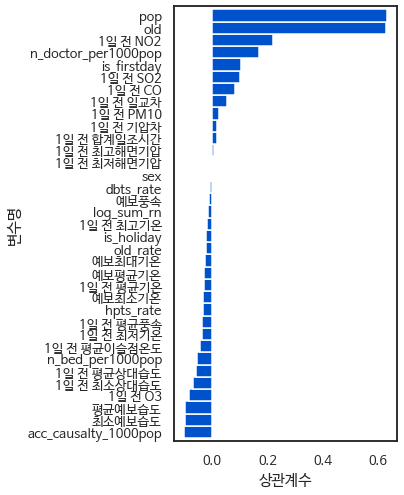

In [30]:
fig, ax = plt.subplots(figsize=(4, 8))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
_ = pd.DataFrame(train_dt[predictors + [response_col]].corr()[response_col]).iloc[:-1].sort_values(by='frequency').plot(kind='barh',width=1, ax=ax, color='#0052CC')
_.set_xlabel("상관계수", fontsize=15)
_.set_ylabel("변수명", fontsize=15)
_.tick_params(labelsize=13)
ax.get_legend().remove()

In [42]:
ccorr =pd.DataFrame(train_dt[predictors + [response_col]].corr()[response_col]).iloc[:-1].sort_values(by='frequency', ascending=True)

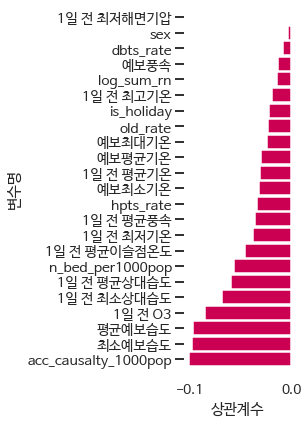

In [71]:
fig, ax = plt.subplots(figsize=(4.5, 6))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
_ = ccorr.loc[ccorr['frequency']<0].plot(kind='barh',width=0.9, ax=ax, color='#CC0052')
_.set_xlabel("상관계수", fontsize=15)
_.set_ylabel("변수명", fontsize=15)
_.tick_params(labelsize=14)
ax.get_legend().remove()
ax.yaxis.tick_left()
sns.despine(left=True, bottom=True)
plt.tight_layout()

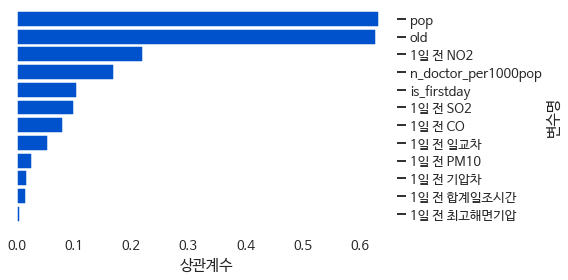

In [72]:
fig, ax = plt.subplots(figsize=(8, 4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
_ = ccorr.loc[ccorr['frequency']>0].plot(kind='barh',width=0.9, ax=ax, color='#0052CC')
_.set_xlabel("상관계수", fontsize=15)
_.set_ylabel("변수명", fontsize=15)
_.tick_params(labelsize=13)
ax.get_legend().remove()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
sns.despine(left=True, bottom=True)
plt.tight_layout()

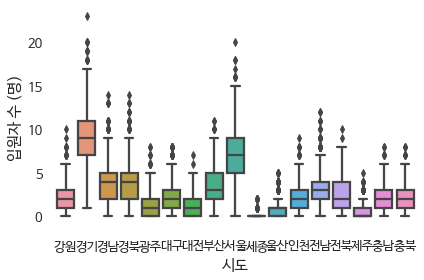

In [58]:
bb = back_dat.groupby(['area', 'date'])['freq'].sum().reset_index()
bb['year'] = bb.date.dt.year
bb['month'] = bb.date.dt.month
bb['weekday'] = bb.date.dt.strftime("%A")
bb['weekday'] = pd.Categorical(bb['weekday'],categories=[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'],ordered=True)
bb['season'] = bb['month'].map(month_to_season)
bb['season'] = pd.Categorical(bb['season'],categories=[ '봄', '여름', '가을', '겨울'],ordered=True)
bb['kor_weekday'] = bb['weekday'].map(eng_to_kor)

fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")

weekday_g = sns.boxplot( x='area', y='freq' ,data=bb, ax=ax)
#weekday_g.set_title("요일별 입원자 수 (전국 단위)", fontsize=18)
weekday_g.set_xlabel("시도", fontsize=15)
weekday_g.set_ylabel("입원자 수 (명)", fontsize=15)
weekday_g.tick_params(labelsize=13)
sns.despine(left=True, bottom=True)
plt.tight_layout()

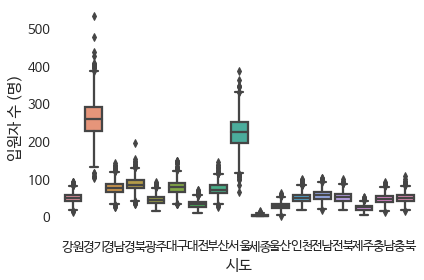

In [59]:
bb = train_dt.groupby(['area', 'yyyymmdd'])['acc_occurence'].sum().reset_index()
bb['year'] = bb.yyyymmdd.dt.year
bb['month'] = bb.yyyymmdd.dt.month
bb['weekday'] = bb.yyyymmdd.dt.strftime("%A")
bb['weekday'] = pd.Categorical(bb['weekday'],categories=[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'],ordered=True)
bb['season'] = bb['month'].map(month_to_season)
bb['season'] = pd.Categorical(bb['season'],categories=[ '봄', '여름', '가을', '겨울'],ordered=True)
bb['kor_weekday'] = bb['weekday'].map(eng_to_kor)

fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")

weekday_g = sns.boxplot( x='area', y='acc_occurence' ,data=bb, ax=ax)
#weekday_g.set_title("요일별 입원자 수 (전국 단위)", fontsize=18)
weekday_g.set_xlabel("시도", fontsize=15)
weekday_g.set_ylabel("입원자 수 (명)", fontsize=15)
weekday_g.tick_params(labelsize=13)
sns.despine(left=True, bottom=True)
plt.tight_layout()

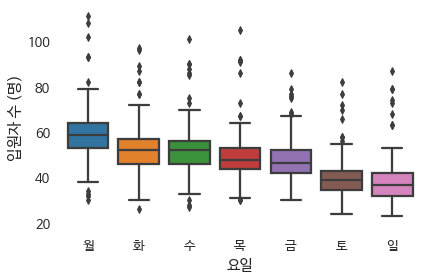

In [193]:
aa = back_dat.groupby(['date'])['freq'].sum().reset_index()
aa['year'] = aa.date.dt.year
aa['month'] = aa.date.dt.month
aa['weekday'] = aa.date.dt.strftime("%A")
aa['weekday'] = pd.Categorical(aa['weekday'],categories=[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'],ordered=True)
aa['season'] = aa['month'].map(month_to_season)
aa['season'] = pd.Categorical(aa['season'],categories=[ '봄', '여름', '가을', '겨울'],ordered=True)
aa['kor_weekday'] = aa['weekday'].map(eng_to_kor)

fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")

weekday_g = sns.boxplot( x='kor_weekday', y='freq' ,data=aa, ax=ax)
#weekday_g.set_title("요일별 입원자 수 (전국 단위)", fontsize=18)
weekday_g.set_xlabel("요일", fontsize=15)
weekday_g.set_ylabel("입원자 수 (명)", fontsize=15)
weekday_g.tick_params(labelsize=13)
sns.despine(left=True, bottom=True)
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



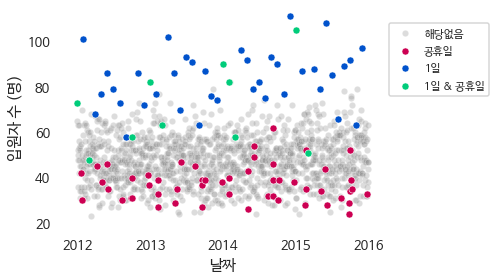

In [83]:
gb4 = back_dat.groupby(['date'])['freq'].sum().reset_index()
# 빨간색 O : 날짜가 1일인 날 입원자 (3월 1일 제외)
# 보라색 X : 3월 1일
first_day = gb4[(gb4['date'].dt.day==1)&~(gb4['date'].isin(holiday_train['date']))]
march_first = gb4[(gb4['date'].dt.day==1)&(gb4['date'].dt.month==3)]
holid = gb4[(gb4['date'].isin(holiday_train['date'])) & ~(gb4['date'].dt.day==1)]
holid_first = gb4[(gb4['date'].dt.day==1)&(gb4['date'].isin(holiday_train['date']))]

fig, ax = plt.subplots(figsize=(7,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")

g4 = sns.scatterplot(x='date', y='freq', data=gb4, color = '#8e8e8e' ,s=40, alpha=0.3 , ax=ax)
#g4.set_title('날짜 특성에 따른 입원자 수 (전국 단위)', fontsize=17)
g4.set_xlabel("날짜", fontsize=15)
g4.set_ylabel("입원자 수 (명)", fontsize=15)
g4.tick_params(labelsize=13)

g5 = sns.scatterplot(x='date', y='freq', data=holid, color='#CC0052', s=50, ax=ax, label='공휴일')
g6 = sns.scatterplot(x='date', y='freq', data=first_day, color='#0052CC', s=50, ax=ax)
g7 = sns.scatterplot(x='date', y='freq', data=holid_first, color='#00CC7A', s=50, ax=ax)
ax.legend( [g4, g5, g6, g7,], labels=['해당없음','공휴일', '1일', '1일 & 공휴일'], bbox_to_anchor=(1.002, 0.95), facecolor='#ffffff', fontsize=11)
sns.despine(left=True, bottom=True)

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 2 != 0:
        label.set_visible(False)

import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%Y')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)


plt.tight_layout()

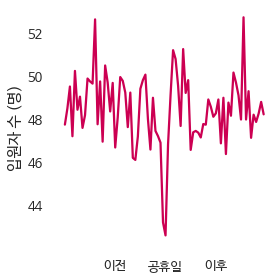

In [200]:
gb4 = back_dat.groupby(['date'])['freq'].sum().reset_index()
def ba_hol_freq(days : int) -> int :
    if days >= 0  : 
        after = gb4[gb4['date'].isin(holiday_train['date'] + Datetime.timedelta(days=days))]
        f_mean = after.freq.mean()

    elif days < 0 :
        before = gb4[gb4['date'].isin(holiday_train['date'] - Datetime.timedelta(days=-days))]
        f_mean = before.freq.mean()
    
    else : 
        print("+++++++++++++++++++++++ ERROR +++++++++++++++++++++++")
    
    return f_mean

# 공휴일 앞뒤로 입원자 수
aaa = []
for i in range(-40, 40) :
    aaa.append(ba_hol_freq(i))

fig, ax = plt.subplots(figsize=(4,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")

hg = sns.lineplot(x=list(range(-40,40)),color='#CC0052', y=aaa)
hg.set_ylabel("입원자 수 (명)", fontsize=15)

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 1 != 0:
        label.set_visible(False)

lab = ['', '', '이전', '공휴일', '이후', '', '']
ax.set_xticklabels(lab)
hg.tick_params(labelsize=13)
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [199]:
[item.get_text() for item in ax.get_xticklabels()]

['', '이전', '공휴일', '이후', '', '', '']

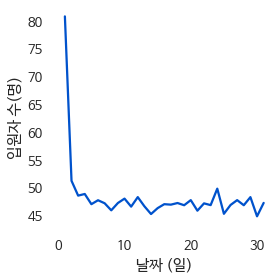

In [204]:
gb4 = back_dat.groupby(['date'])['freq'].sum().reset_index()
nbyd = gb4.groupby(gb4['date'].dt.day).mean().reset_index()

fig, ax = plt.subplots(figsize=(4,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
fg = sns.lineplot(x='date', y= 'freq', color='#0052CC',data=nbyd)
fg.set_xlabel("날짜 (일)", fontsize=15)
fg.set_ylabel("입원자 수(명)", fontsize=15)

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 1 != 0:
        label.set_visible(False)

fg.tick_params(labelsize=13)
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [149]:
[item.get_text() for item in ax.get_xticklabels()]

['-20', '0', '20', '40']

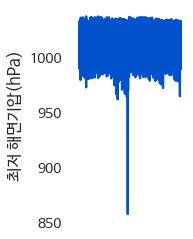

In [57]:
aso = pd.read_csv(mount_dir+'/asosdt.csv', encoding='CP949')
aso = aso[weacol].copy()
fig, ax = plt.subplots(figsize=(2,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
sns.despine(left=True, bottom=True)

#hpa = sns.lineplot(x='yyyymmdd', y= '최저 해면기압(hPa)', color='#0052CC',data=aso)
hpa = aso['최저 해면기압(hPa)'].plot( color='#0052CC')
hpa.set_ylabel("최저 해면기압(hPa)", fontsize=16)
hpa.tick_params(labelsize=14)
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 10 != 0:
        label.set_visible(False)

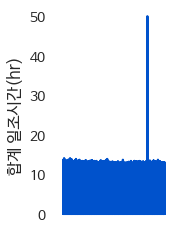

In [58]:
fig, ax = plt.subplots(figsize=(2,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
sns.despine(left=True, bottom=True)
hr = aso['합계 일조시간(hr)'].plot( color='#0052CC')
hr.set_ylabel("합계 일조시간(hr)", fontsize=16)
hr.tick_params(labelsize=14)
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 10 != 0:
        label.set_visible(False)

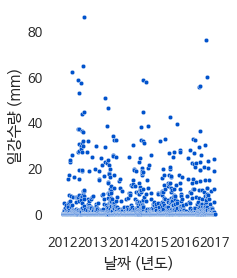

In [63]:
rain = pd.concat([raindt, raindt2016], axis=0)
rrr = rain.groupby('date')['sum_rn'].mean().reset_index()
rrr['year'] =rrr['date'].dt.year
rrr['month'] = rrr['date'].dt.month
rrr['weekday'] = rrr['date'].dt.strftime('%A')
rrr['season'] = rrr['month'].map(month_to_season)
rrr['log_sum_rn'] = np.log1p(rrr['sum_rn'])

fig, ax = plt.subplots(figsize=(3,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
t1 = sns.scatterplot(x='date', y='sum_rn', data=rrr, color= "#0052cc", s=20, ax=ax)
#t1.set_title("일일 평균 강수량 (전국 단위)", fontsize=17)
t1.set_xlabel("날짜 (년도)", fontsize=15)
t1.set_ylabel("일강수량 (mm)", fontsize=15)
t1.tick_params(labelsize=13)
sns.despine(left=True, bottom=True)

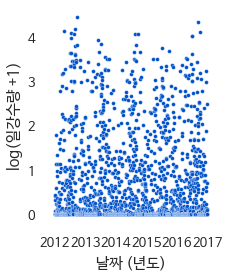

In [64]:
fig, ax = plt.subplots(figsize=(3,4))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
t1 = sns.scatterplot(x='date', y='log_sum_rn', data=rrr, color= "#0052cc", s=15, ax=ax)
#t1.set_title(" ", fontsize=17)
t1.set_xlabel("날짜 (년도)", fontsize=15)
t1.set_ylabel("log(일강수량 +1)", fontsize=15)
t1.tick_params(labelsize=13)
sns.despine(left=True, bottom=True)

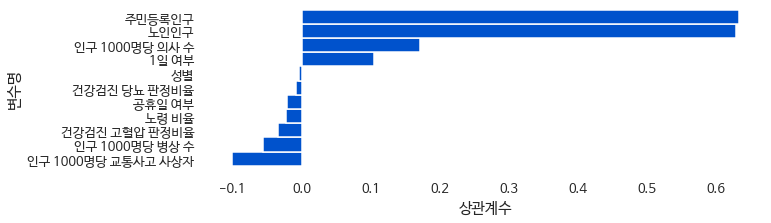

In [223]:
main_col2 = ['area', 'sex', 'weekday', 'is_firstday', 'is_holiday']
fore_col2 = ['예보최대기온', '예보최소기온', '예보평균기온', '최소예보습도', '평균예보습도', '예보풍속']
lag_col2 = ['1일 전 평균기온', '1일 전 최저기온', '1일 전 최고기온', '1일 전 평균풍속', '1일 전 평균이슬점온도', '1일 전 최소상대습도', '1일 전 평균상대습도', '1일 전 최고해면기압',
       '1일 전 최저해면기압', '1일 전 합계일조시간', '1일 전 일교차', '1일 전 기압차', '1일 전 SO2',  '1일 전 CO', '1일 전 O3', '1일 전 NO2', '1일 전 PM10']
acc_col2 = ['acc_causalty_1000pop']
pop_col2 = [ 'pop', 'old']
health_col2 = ['hpts_rate', 'dbts_rate', 'old_rate' ]
hospital_col2 = ['n_doctor_per1000pop', 'n_bed_per1000pop']

predictors2 = main_col2 + fore_col2 + lag_col2 + acc_col2 + pop_col2 + hospital_col2 + health_col2 + ['log_sum_rn']
predictors3 = main_col2 + pop_col2 + acc_col2 + health_col2 + hospital_col2

fig, ax = plt.subplots(figsize=(10, 3))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")
vdf = pd.DataFrame(train_dt[predictors3 + [response_col]].corr()[response_col]).iloc[:-1].sort_values(by='frequency')
vdf.index = ['인구 1000명당 교통사고 사상자','인구 1000명당 병상 수', '건강검진 고혈압 판정비율','노령 비율', '공휴일 여부','건강검진 당뇨 판정비율' , 
             '성별', '1일 여부' , '인구 1000명당 의사 수' ,'노인인구', '주민등록인구']
_ = vdf.plot(kind='barh', ax=ax, color='#0052CC', width = 1)
_.set_xlabel("상관계수", fontsize=15)
_.set_ylabel("변수명", fontsize=15)
_.tick_params(labelsize=13)
sns.despine(left=True, bottom=True)
ax.get_legend().remove()

In [300]:
vdf

,frequency
인구 1000명당 교통사고 사상자,-0.100816
인구 1000명당 병상 수,-0.056280
건강검진 고혈압 판정비율,-0.034265
노령 비율,-0.023327
공휴일 여부,-0.021586
건강검진 당뇨 판정비율,-0.007975
성별,-0.003406
1일 여부,0.105135
인구 1000명당 의사 수,0.171029
노인인구,0.629231
